# Generative modelling in deep learning

#### Student : Yonatan DELORO ;  Contact : yonatan.deloro@eleves.enpc.fr

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by an other algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some ways to compare two given distributions $p_D$ and $p_\theta$?**

- Examples of a method comparing the density of the distributions :

> 1) The **Kullback-Leibler divergence** from $p_{\theta}$ to $p_D$ is defined  as follows :

> $$D_{KL}(p_D || p_{\theta}) = E_{x \sim p_D} \left[ \log \frac{p_D(x)}{p_{\theta}(x)} \right] = - E_{x \sim p_D} \left[ \log p_{\theta}(x) \right] - H(p_D) $$

> where $H$ denotes the entropy of a distribution.  Thus, $D_{KL}(p_D || p_{\theta})$ can be seen as the difference between the expected number  of bits needed to code samples from $p_D$ using a code optimized for $p_{\theta}$, and the one needed to code samples from $p_D$ using a code optimized for $p_{D}$. From a Bayesian point of view, it can also be interpreted as the expected amount of information gained when we "discover" samples are sampled from $p_D$ while we thought there were sampled from $p_{\theta}$ (prior).

> $D_{KL} (p_D || p_{\theta})$ will penalize more the generator if it misses modes of $p_D$ than if some generated images do not look real (higher penalty if $p_{\theta}(x) \rightarrow 0$ when $p_D(x)>0$ than if $p_{\theta}(x)>0$ when $p_D(x) \rightarrow 0$). Alternatively, one could also choose $D_{KL} (p_{\theta} || p_D)$ which would favor the realism of the generated samples over the diversity of these (higher penalty if $p_{\theta}(x) > 0$ when $p_D(x) \rightarrow 0$ than  if $p_{\theta}(x)\rightarrow0$ when $p_D(x) > 0 $).

- Example of a method comparing the values sampled from the distributions

> 2) The **Maximum Mean Discrepancy (MMD)** between $p_{\theta}$ and $p_D$ is  defined as the maximum squared difference between the expectation of $\phi$ over $p_D$ and the expectation of $\phi$ over $p_{\theta}$, where $\phi$ belongs to a certain class of functions $F$.

> $$MMD(p_D, p_{\theta}) = \sup_{\phi \in F} (E_{x \sim p_D}[\phi(x)] - E_{x \sim p_{\theta}}[\phi(x)])$$

> $F$ is generally choosen to be the unit ball of a universal RKHS $H$, to be rich enough to identify whether two distributions are equal (MMD(p,q) is 0 iff p=q), and restrictive enough to contain useful finite sample estimates. Then : $$MMD(p_D, p_{\theta}) = \sup_{||\phi||_H \leq 1} (E_{x \sim p_D}[\phi(x)] - E_{x \sim p_{\theta}}[\phi(x)]) = ||\mu_{p_D} - \mu_{p_{\theta}}||_{H}$$ where $\mu_p$ denotes the mean embedding of distribution $p$, defined as the element of $H$ such that $E_{x \sim p}[\phi(x)] = <\phi, \mu_p>_H$, $\phi \in H$.

> Such MMD can be estimated from independent samples drawn from $p_{\theta}$ and $p_D$, as a sum of kernel evaluations : 

> $$MMD(p_D, p_{\theta})^2 = E_{x,x' \sim p_D,~ y,y' \sim p_{\theta}}[k(x,x') - 2k(x,y) + k(y,y')]$$


> with $k$ is the kernel of the universal RKHS.

Sources : https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence ;  http://www.stat.cmu.edu/~ryantibs/journalclub/mmd.pdf 

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them directly.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> - Caveat of methods comparing the densities (as the KL divergence) : 

> As we have only access to the data distribution $p_D$ through samples, we cannot compute the integral of the KL divergence analytically. We need to be able to **discretize the space to estimate the density of $p_D$ from the samples we have access to, which is a hard task in high dimension domains**. 

> - Caveat of methods comparing the values sampled from the distributions directly (as the MMD) :

> Here the main problem does not come from $p_D$ for which we observe directly samples, but from $p_{\theta}$. Indeed, we face instead the issue of **sampling from the distribution $p_{\theta}$, which can be expensive in high dimension domains**.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strenghts and weaknesses.

In [1]:
import sys
print(sys.version)

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

%matplotlib inline
import matplotlib.pyplot as plt


#print(torch.cuda.is_available())

3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimentional gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise?**

> A priori, the higher N is, the higher the expressive power / capacity of the network (the larger the space of learnable functions), and the larger the time to learn how to map the latent space to the data. In practice the third point might not necessary hold.


By construction, this generator structure only allows sampling of the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$. Such a model seems to need a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to differentiate examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator (whose output is denoted by $D(x)$) is trained using a classic discrimination loss, so that $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$

So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the JSD between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> The Jensen-Shannon Divergence is a symmetrized version of the Kullback Leibler Divergence, defined as :

$$JSD(p_\theta || p_D) = \frac{1}{2} \left( D_{KL} \left(p_\theta ||\frac{p_D + p_\theta}{2} \right) + D_{KL} \left(p_D || \frac{p_D + p_\theta}{2}\right) \right)$$

> When the discriminator is optimal, the generator aims at maximizing $ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $. But, contrarily to the KL divergence, **the JSD is upper bounded**. Indeed :

$$\begin{align} JSD(p_\theta || p_D) &= \frac{1}{2} \left( D_{KL} \left(p_\theta ||\frac{p_D + p_\theta}{2} \right) + D_{KL} \left(p_D || \frac{p_D + p_\theta}{2}\right) \right) \\
&= \frac{1}{2} \left( \int_x p_\theta(x) \log \frac{2p_\theta(x)}{p_D(x) + p_\theta(x)} + \int_x p_D(x) \log \frac{2p_D(x)}{p_D(x) + p_\theta(x)} \right) \\
&= \frac{1}{2} \left( \int_x (p_D(x) + p_\theta(x)) \left( \frac{p_\theta(x)}{p_D(x) + p_\theta(x)} \log \frac{2p_\theta(x)}{p_D(x) + p_\theta(x)} + \frac{p_D(x)}{p_D(x) + p_\theta(x)} \log \frac{2p_D(x)}{p_D(x) + p_\theta(x)}  \right) \right) \\
&= \frac{1}{2} \int_x (p_D(x) + p_\theta(x))  \left( \log (2) - H_{Y \sim Ber \left( \frac{p_\theta(x)}{p_D(x) + p_\theta(x)}\right) } [Y] \right)\\
&\leq \frac{1}{2} \int_x (p_D(x) + p_\theta(x))   \log (2)\\
&=\log (2)
\end{align}$$

> where $H(X)$ denotes the entropy of variable $X$, which is nonnegative.

> **CAVEAT : Therefore, we can suspect the gradient of $JSD(p_\theta || p_D)$ with respect to $\theta$ to be saturated when $p_\theta$ is far from $p_D$, in which case the GAN will learn slowly**.

> If we consider the extreme example mentionned in ressource (1), where we want to fit $p_D : (X,Y) \sim (\delta_0,U)$ the distribution on $[0,1]^2$ (where $\delta_0$ is the Dirac in 0 and $U$ the uniform distribution on $[0,1]$) with a distribution of the form $p_\theta: (X,Y) \sim (\delta_{\theta},U)$. Then $p_D(x,y) = 1_{x=0}$,  $p_{\theta}(x,y) = 1_{x=\theta}$, and, when $\theta \neq 0$, we get : $JSD(p_\theta || p_D) = \frac{1}{2} \left( 1 . \log(\frac{2}{1+1}) + 1 . \log(\frac{2}{1+1}) \right) =  \log(2)$.
Therefore, the divergence is always maximal, equal to its upped bound $\log(2)$, except when we fit exactly the data distribution, where it is 0. Here, the JSD is even non differentiable at 0, while we would obviously prefer a smooth distance.

> This example worked as distributions had disjoint supports, but we can expect a similar phenomena if we want for instance to approximate a very peaked Gaussian in a family of peaked Gaussians, in which case the gradient of the JSD between $\mathcal{N}(0,\epsilon)$ and $\mathcal{N}(\theta,\epsilon)$ (with very small $\epsilon$) will be saturated whenever $\theta$ would be a bit far from 0 (see ressource (2)).


> However, the JSD has also important advantages, among which : 1) it is always non-negative and is zero if and only if $p_\theta=p_D$, hence leading to a unique global minimum of $ \mathcal{L}_D$, where the generative model perfectly replicates the data. ; 2) $JSD(p_\theta || p_D)$ can be seen as a compromise between $D_{KL} (p_D || p_{theta})$ (penalizes when modes of the distribution $p_D$ are missed) and $D_{KL} (p_{theta}  || p_D)$ (penalizes when unrealistic images are generated).

Sources : (0) https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence ; (1) https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html?fbclid=IwAR2gabkME-jVNzbREeOKF3J2oGtOVYWs2AAVQcebb1ew5ZVc23XftaWIsfw ; (2) https://medium.com/@jonathan_hui/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b 



Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what can this imply?**

> The risk is that the generator could miss certain modes of the data distribution, if it already succeeds to fool the discriminator generating very realistic samples from a few modes.

> Thus, an implication is that the discriminator and the generator should learn at similar paces to reach an equilibrium ("fair two-players game"). Indeed :

> - If the discriminator is far from being optimal, this loss $\mathcal{L}_G$ is also not a good objective for the generator, therefore the generator does not have an accurate feedback.

> - At the oppositive, if the discriminator is optimal, the gradient of $\mathcal{L}_G$ will vanish to zero,  therefore the generator will have a very weak feedback, which will result into a very slow training.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be 25 Gaussian distributions with small variance, distributed on a $5\times 5$ grid.

In [2]:
# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the 25-gaussian dataµset.
    
    return a torch tensor of dimensions (batchlen, 2)
    """
    # to sample from the gaussian mixture, we first sample the means for each point, then
    # add a gaussian noise with small variance
    samples = torch.multinomial(torch.tensor([0.2,0.2,0.2,0.2,0.2]), 2*batchlen, replacement=True)
    means = (2.0 * (samples - 2.0)).view(batchlen,2).type(torch.FloatTensor)
    return torch.normal(means, 0.05)

Let's plot a batch, to see what the dataset looks like.

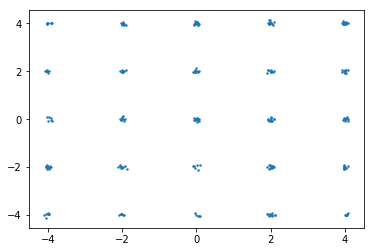

In [3]:
batch = generate_batch(256)

plt.scatter(batch[:,0], batch[:,1], s=2.0, label='Batch of data from our gaussian mixture dataset')
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

When representing a binary classifier with a neural network, it is better for the last layer to consist of only a sigmoid activation, so that the output values will be between 0 and 1 and stand for the probability (according to the classifier) that the input is of the first class. The output is thus of the form $\mathrm{sigmoid}(h)$. The loss involves quantities such as $-\log(\mathrm{sigmoid}(h))$. For numerical stability reasons, it is recommended to rewrite the loss in order to make use of the $\mathrm{softplus}$ function defined by $\mathrm{softplus}(h) = \log(1 + \exp(h))$ and provided in PyTorch as `torch.softplus`.
As the $\mathrm{softplus}(h)$ formulation of the loss already contains the sigmoid activation, in practice the last layer of the discrimator network will not have any activation function (being just $h$).

In [4]:
# Choose a value for the prior dimension
PRIOR_N = 10 #1    
    
# Define the generator
class Generator(nn.Module):
    
    def __init__(self, depth, width):
        #depth : number of layers of the network (including output layer)
        #width : number of neurons per layer (except for last layer) 
        
        super().__init__()
        
        self.depth = depth
        
        self.fc_init = nn.Linear(PRIOR_N, width)
        
        if self.depth>2:
            self.hidden = nn.ModuleList()
            for d in range(self.depth-2):
                self.hidden.append(nn.Linear(width, width))
            
        self.fc_end = nn.Linear(width, 2)
        
    def __call__(self, z):
        
        h = F.relu(self.fc_init(z))
        
        if self.depth>2:
            for d in range(self.depth-2):
                h = F.relu(self.hidden[d](h))
            
        return self.fc_end(h)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, depth, width):
        #depth : number of layers of the network (including output layer)
        #width : number of neurons per layer (except for last layer)
    
        super().__init__()
        
        self.depth = depth
        
        self.fc_init = nn.Linear(2, width)
        
        if self.depth>2:
            self.hidden = nn.ModuleList()
            for d in range(self.depth-2):
                self.hidden.append(nn.Linear(width, width))
            
        self.fc_end = nn.Linear(width, 1)
        
    def __call__(self, z):
        
        h = F.relu(self.fc_init(z))
        
        if self.depth>2:
            for d in range(self.depth-2):
                h = F.relu(self.hidden[d](h))

        return self.fc_end(h)

With these classes in shape, only the training loop is still missing. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, its gradient will vanish (as seen in **Q4**) and thus no information will be passed to the generator.

We will then train the discriminator a fixed number of times between each training iteration of the generator.

In [5]:
BATCHLEN = 128

def train_GAN(N_ITER = 14001, TRAIN_RATIO=1, depth_gen=2, width_gen=2, depth_discr=2, width_discr=2, viz=True):
    #N_ITER :  Total number of training iterations for the GAN
    #TRAIN_RATIO : number of times the discriminator is trained at each iteration (ie. for one training of the generator)
    #depth_gen/depth_discr : number of layers of the generator/discriminator
    #width_gen/width_discr : number of neurons per layer (except last one) for the generator/discriminator    
    #if viz is True: print evolution of generator loss, discriminator loss at the end of the training,
    #and generated data at different steps of the training
    #returns history of generator loss and discriminator loss throughout training
    
    generator = Generator(depth_gen, width_gen)
    optim_gen = torch.optim.Adam(generator.parameters(), lr=0.005, betas=(0.5,0.9))
    discriminator = Discriminator(depth_discr, width_discr)
    optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.005, betas=(0.5,0.9))

    history_disc_loss = np.zeros(N_ITER)
    history_gen_loss = np.zeros(N_ITER)

    for i in range(N_ITER):

        # train the discriminator
        for _ in range(TRAIN_RATIO):
            discriminator.zero_grad()
            real_batch = generate_batch(BATCHLEN)
            fake_batch = generator.generate(BATCHLEN)
            # Compute here the discriminator loss, using functions like torch.sum, torch.exp, torch.log,
            # torch.softplus, using real_batch and fake_batc
            output_real = discriminator(real_batch)
            output_fake = discriminator(fake_batch)
            disc_loss = F.softplus(-output_real) + F.softplus(output_fake)
            disc_loss = disc_loss.mean() 
            history_disc_loss[i] += disc_loss.item()
            disc_loss.backward()
            optim_disc.step()
            
        history_disc_loss[i] /= TRAIN_RATIO

        # train the generator
        generator.zero_grad()
        fake_batch = generator.generate(BATCHLEN)
        # Compute here the generator loss, using fake_batch
        output_fake = discriminator(fake_batch)
        #gen_loss = - F.softplus(output_fake)
        gen_loss = F.softplus(-output_fake) #advised in Q6
        gen_loss = gen_loss.mean() 
        history_gen_loss[i] = gen_loss.item()
        gen_loss.backward()
        optim_gen.step()
        
        if viz:
            
            if (i==N_ITER-1):
                plt.plot(np.arange(i),history_disc_loss[:i]); 
                plt.xlabel("iterations"); plt.ylabel("discriminator loss"); plt.show()
                plt.plot(np.arange(i),history_gen_loss[:i]); 
                plt.xlabel("iterations"); plt.ylabel("generator loss"); plt.show()    

            
            if (i%2000 ==0) and i>0:
                print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
                # plot the result
                real_batch = generate_batch(1024)
                fake_batch = generator.generate(1024).detach()
                plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
                plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
                plt.legend()
                plt.show()       
            
    return history_gen_loss, history_disc_loss

step 2000: discriminator: 1.266e+00, generator: 7.657e-01


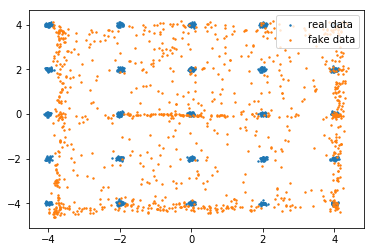

step 4000: discriminator: 1.178e+00, generator: 7.838e-01


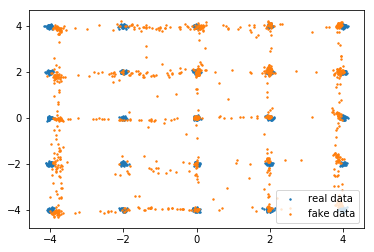

step 6000: discriminator: 1.270e+00, generator: 7.598e-01


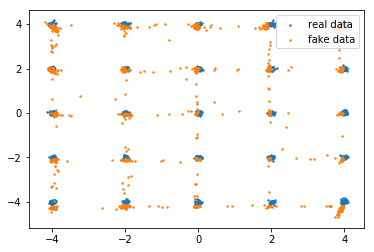

step 8000: discriminator: 1.424e+00, generator: 7.910e-01


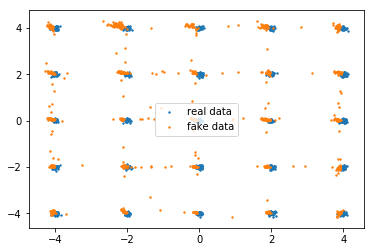

step 10000: discriminator: 1.329e+00, generator: 7.391e-01


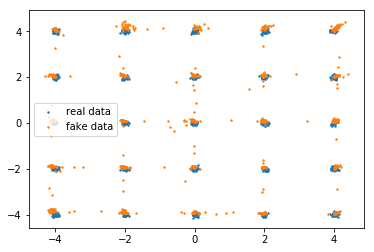

step 12000: discriminator: 1.371e+00, generator: 7.516e-01


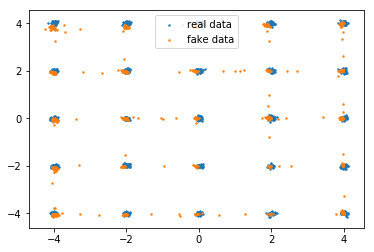

step 14000: discriminator: 1.337e+00, generator: 7.828e-01


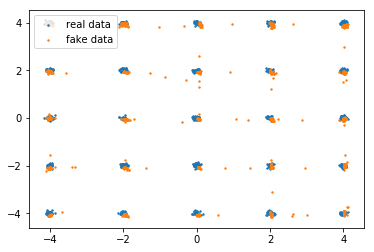

step 16000: discriminator: 1.363e+00, generator: 7.937e-01


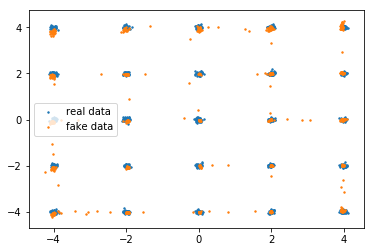

step 18000: discriminator: 1.407e+00, generator: 6.839e-01


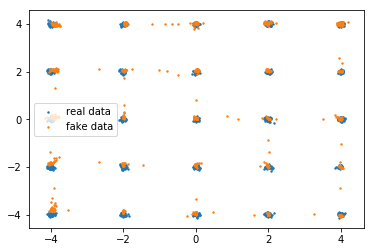

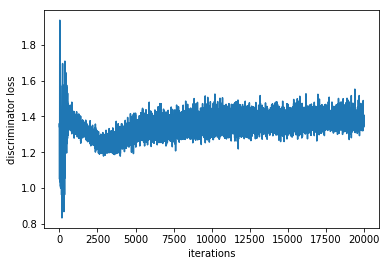

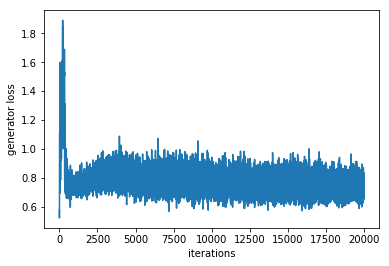

step 20000: discriminator: 1.366e+00, generator: 7.542e-01


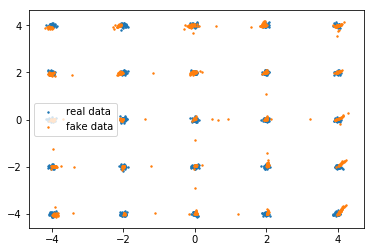

In [6]:
gen_loss, disc_loss = train_GAN(N_ITER = 20001, TRAIN_RATIO=1, depth_gen=3, width_gen=100, depth_discr=2, width_discr=100, viz=True)

Complete the previous code and train your model.

> For this purpose, I rewrote:

> $$
\begin{align}
\mathcal{L}_D &= \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] \\
&= \mathbb{E}_{p_D} \left[ -\log sigmoid(N_D(x)) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-sigmoid(N_D(x))\right) \right] \\
&= \mathbb{E}_{p_D} \left[ -\log \frac{1}{1+\exp(-N_D(x))} \right] + \mathbb{E}_{p_\theta} \left[ -\log \frac{1}{1+\exp(N_D(x))} \right] \\
&= \mathbb{E}_{p_D} \left[ softplus(-N_D(x)) \right] + \mathbb{E}_{p_\theta} \left[  softplus(N_D(x))\right]
\end{align}$$

> And :

> $$ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) = \mathbb{E}_{p_\theta} \left[-softplus(N_D(x))\right]
 $$
 
> However, given the advice given after Q6, I finally exhanged this expression for :

> $$ \mathcal{L}_G = - \mathbb{E}_{p_\theta} \log(D(x)) = \mathbb{E}_{p_\theta} \left[softplus(-N_D(x))\right]
 $$
 
 
> where I denote $N_D(x)$ the output of the discriminative network (as implemented) for the input $x$, $sigmoid(x) = \frac{1}{1+\exp(-x)}$ and $\mathrm{softplus}(x) = \log(1 + \exp(x))$ 

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> $$ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) 
 $$
 
 > This loss is equal to 0 when the discriminator detects any fake data ($D(x)$ the output probability of "$x$ is true" is 0), and tends to $-\infty$ when $D(x)$ tends to zero, ie. when the discriminator tends to be always fooled. **As we want to minimize $\mathcal{L}_G$, it is problematic that $\mathcal{L}_G$ is not bounded inferiorly**.
 
 > Instead, we must prefer $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ which is equal to 0 when to the discriminator is always fooled and which tends to $+\infty$ when $D(x)$ tends to 1, ie. when the discriminator tends to detect any fake data. **The minimum of this new $\mathcal{L}_G$ is 0 and is reached when the discriminator is always fooled**.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

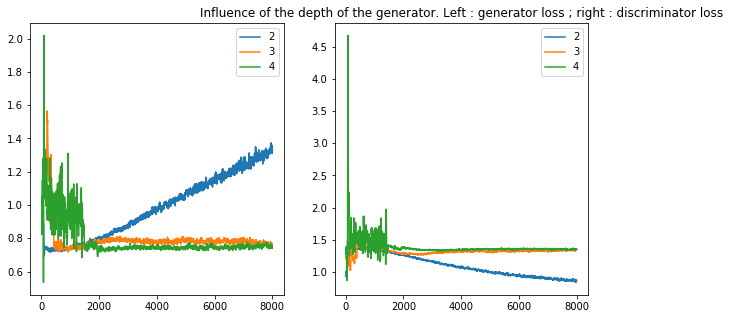

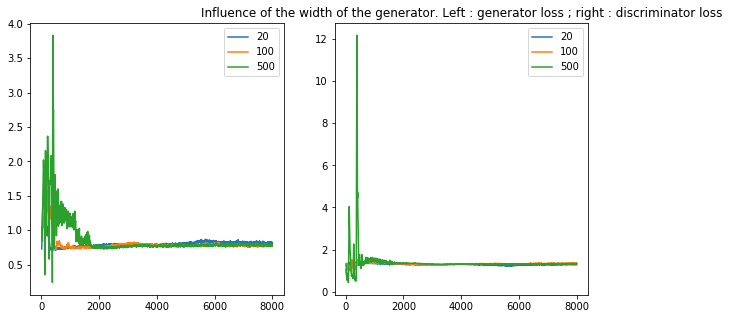

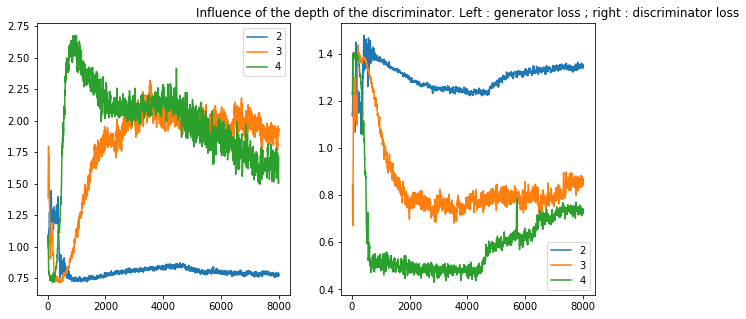

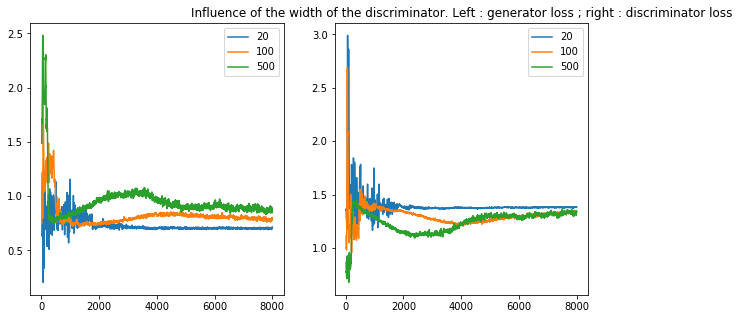

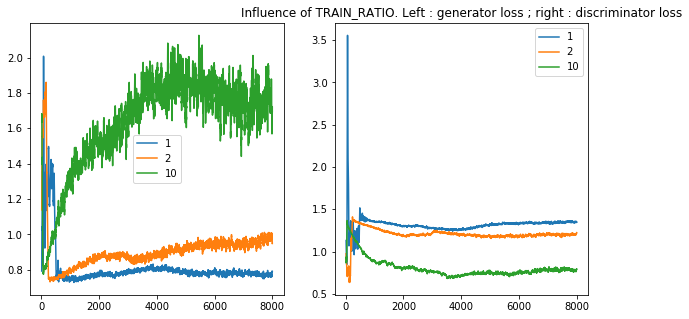

In [7]:
depths = [2,3,4]
widths = [20,100,500]
TRAIN_RATIOs = [1,2,10]
N_ITER = 8000

nb_iter_average = 20 #computing moving average of loss over nb_iter_average iterations

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for d in depths:
    history_gen_loss, history_dis_loss = train_GAN(N_ITER=N_ITER, TRAIN_RATIO=1, depth_gen=d, width_gen=100, depth_discr=2, width_discr=100, viz=False)
    axes[0].plot(pd.Series(history_gen_loss).rolling(window=nb_iter_average).mean().values,label=d)
    axes[1].plot(pd.Series(history_dis_loss).rolling(window=nb_iter_average).mean().values,label=d)
axes[0].legend()
axes[1].legend()
plt.title("Influence of the depth of the generator. Left : generator loss ; right : discriminator loss")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for d in widths:
    history_gen_loss, history_dis_loss = train_GAN(N_ITER=N_ITER, TRAIN_RATIO=1, depth_gen=3, width_gen=d, depth_discr=2, width_discr=100, viz=False)
    axes[0].plot(pd.Series(history_gen_loss).rolling(window=nb_iter_average).mean().values,label=d)
    axes[1].plot(pd.Series(history_dis_loss).rolling(window=nb_iter_average).mean().values,label=d)
axes[0].legend()
axes[1].legend()
plt.title("Influence of the width of the generator. Left : generator loss ; right : discriminator loss")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for d in depths:
    history_gen_loss, history_dis_loss = train_GAN(N_ITER=N_ITER, TRAIN_RATIO=1, depth_gen=3, width_gen=100, depth_discr=d, width_discr=100, viz=False)
    axes[0].plot(pd.Series(history_gen_loss).rolling(window=nb_iter_average).mean().values,label=d)
    axes[1].plot(pd.Series(history_dis_loss).rolling(window=nb_iter_average).mean().values,label=d)
axes[0].legend()
axes[1].legend()
plt.title("Influence of the depth of the discriminator. Left : generator loss ; right : discriminator loss")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for d in widths:
    history_gen_loss, history_dis_loss = train_GAN(N_ITER=N_ITER, TRAIN_RATIO=1, depth_gen=3, width_gen=100, depth_discr=2, width_discr=d, viz=False)
    axes[0].plot(pd.Series(history_gen_loss).rolling(window=nb_iter_average).mean().values,label=d)
    axes[1].plot(pd.Series(history_dis_loss).rolling(window=nb_iter_average).mean().values,label=d)
axes[0].legend()
axes[1].legend()
plt.title("Influence of the width of the discriminator. Left : generator loss ; right : discriminator loss")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for d in TRAIN_RATIOs:
    history_gen_loss, history_dis_loss = train_GAN(N_ITER=N_ITER, TRAIN_RATIO=d, depth_gen=3, width_gen=100, depth_discr=2, width_discr=100, viz=False)
    axes[0].plot(pd.Series(history_gen_loss).rolling(window=nb_iter_average).mean().values,label=d)
    axes[1].plot(pd.Series(history_dis_loss).rolling(window=nb_iter_average).mean().values,label=d)
axes[0].legend()
axes[1].legend()
plt.title("Influence of TRAIN_RATIO. Left : generator loss ; right : discriminator loss")
plt.show()

> *Experimental setup* : the reference model is TRAIN_RATIO=1, depth_gen=3, width_gen=100, depth_discr=2, width_discr=100. In each experiment shown above, we make one of these five parameters vary to observe its impact on training.

> *Preliminary note* : let's first underline that, if such curbs give insights about the impact of the various parameters on the training, we should be careful on how to interpret them : the evolution of the generator loss is always related to the quality of the discriminator. In other words, the loss of the generator can increase while the quality of the generated images increases (if the discriminator learns faster), and vice versa.

> - *Generator depth* : If the generator depth is too small (2), its loss always increases while the discriminator loss always decreases, which might be interpreted as a lack of expressive power to generate data which could fool the discriminator. At the opposite, if the generator depth is too large (4), we see that the training is very unstable (the discriminator and the generator losses vary in opposite directions from one iteration to the other) and it takes much more time to reach the "Nash equilibrium" of the game. Hence, the generator depth should be large enough to give enough expressive power to the generator, but not too large to still be trained easily.

> - *Generator width* : The generator width also controls its expressive power, but it seems that the more significant differences in the GAN training can be observed playing on the depth. Again we observe that we reach faster an equilibrium when the generator width is not too large.

> - *Discriminator depth* : If the discriminator depth is too large, then its loss decreases straightly while the generator loss increases straightly before diminishing slowly. It may be interpreted that if the expressive power of the discriminator is too high, the generator loss is very close from its true objective but the more likely its gradient is to vanish and the generator training to get slow.

> - *Discriminator width* : The discriminator width seems to have less impact on the time necessary to reach the equilibrium.  But again, if it is too low, we can suspect that we will never manage to generate realistic data at the equilibrium (the generator loss is far from its true objective if the discriminator predictions are not good), and, if it is too large, the JSD gradient may vanish, providing weak feedback to the generator.

> - *TRAIN RATIO* : Finally, the higher the TRAIN RATIO parameter, the smaller the discriminator loss at the equilibrium and the higher the generator loss. Intuitively, the higher TRAIN RATIO, the faster the discriminator learns with respect to the generator, the closer the generator loss is from its true objective, but the more likely its gradient is to vanish and the generator training to be slow.

> *Conclusion* : It seems that a good strategy to choose the parameters is the following : provided a reasonable number of neurons per layer (width), we should first play on the depths of the generator and of the discriminator networks to obtain a "fair two-players" game which can reach an equilibrium. Choosing the right TRAIN RATIO parameter may also enable to tradeoff between (i) the closeness of the generator loss to its true objective (as this loss depends on the discriminator performances), and (ii) the non-vanishing of the generator loss gradient.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

### Variational AutoEncoders

An other well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \log p_\theta(x)$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.

**Q8: Prove this equivalence.**

> $\begin{align} D_{KL}(p_D \| p_\theta) &= E_{x \sim p_D} \left[ \log \frac{p_D(x)}{p_{\theta}(x)} \right] \\ &= E_{x \sim p_D} \left[ \log p_{D}(x) \right] - E_{x \sim p_D} \left[ \log p_{\theta}(x) \right] \\  &= cste - E_{x \sim p_D} \left[ \log p_{\theta}(x) \right] \end{align}$


> since $E_{x \sim p_D} \left[ \log p_{D}(x) \right]$ does not depend on $\theta$.

> Consequently, maximizing $\mathbb{E}_{p_D} \log p_\theta(x)$ is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$

However, the class of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution like so: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Where here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)ds$ is an infinite mixture of gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce an other, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} - \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms form a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> $D_{KL}(q_\phi(z | x) \| p(z)) = E_{q_\phi(z | x)} \left[ \log \frac{q_\phi(z | x)}{p(z)} \right]$ assigns a high penalty when $q_\phi(z | x)>0$ and $p(z)\rightarrow 0$ and a low one when $q_\phi(z | x) \rightarrow  0$ and $p(z)>0$. The second point can explicit a risk of not sampling $p(z)$ during the training process : some unrealistic images might be generated at test time, even if the divergence term is low. 

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> Notations : we will denote $\mathrm{Tr}$ the Trace operator, $|.|$ the determinant operator, and $Diag(D)$ the diagonal matrix of diagonal the vector $D$.

> Our assumptions translate into :

> $$  p(z) = \frac{1}{(2\pi)^{d/2}} \exp \left[-\frac{z^Tz}{2}\right]$$

> $$  q_\phi(z | x) = \frac{1}{(2\pi)^{d/2} |Diag(\sigma_\phi(x)^2)|^{1/2}} \exp \left[-\frac{1}{2} (z-\mu_\phi(x))^TDiag\left(\frac{1}{\sigma_\phi(x)^2}\right)(z-\mu_\phi(x))\right]$$

> Thus : $$\frac{q_\phi(z | x)}{p(z)} = \frac{1}{|Diag(\sigma_\phi(x)^2)|^{1/2}} \exp \left[-\frac{1}{2} (z-\mu_\phi(x))^TDiag\left(\frac{1}{\sigma_\phi(x)^2}\right)(z-\mu_\phi(x)) + \frac{z^Tz}{2}\right] $$

> or in other words : \begin{align} \log \frac{q_\phi(z | x)}{p(z)} &= - \frac{1}{2} \log |Diag(\sigma_\phi(x)^2)| + \frac{1}{2} z^T \left(Id-Diag\left(\frac{1}{\sigma_\phi(x)^2}\right)\right) z \\&+ \mu_\phi(x)^TDiag\left(\frac{1}{\sigma_\phi(x)^2}\right)z - \frac{1}{2}\mu_\phi(x)^TDiag\left(\frac{1}{\sigma_\phi(x)^2}\right)\mu_\phi(x) \end{align}

> Therefore : \begin{align} 
D_{KL}(q_\phi(z | x) \| p(z)) &= \int_z q_\phi(z | x) \log \frac{q_\phi(z | x)}{p(z)} dz \\
&= - \frac{1}{2} \log |Diag(\sigma_\phi(x)^2)| - \frac{1}{2}\mu_\phi(x)^TDiag\left(\frac{1}{\sigma_\phi(x)^2}\right)\mu_\phi(x)\\
&+ \frac{1}{2}\int_z z^T \left(Id-Diag\left(\frac{1}{\sigma_\phi(x)^2}\right)\right) z q_\phi(z | x) dz 
+ \mu_\phi(x)^T Diag\left(\frac{1}{\sigma_\phi(x)^2}\right) \int_z z q_\phi(z | x) dz \\
\end{align}


> But $$  \int_z z q_\phi(z | x) dz = E_{Z \sim q_\phi(z | x)}[Z]  = \mu_\phi(x)$$

> And  \begin{align} \int_z z^T \left(Id-Diag\left(\frac{1}{\sigma_\phi(x)^2}\right) \right) z q_\phi(z | x) dz 
&= \int_z \mathrm{Tr} \left[ z^T \left(Id-Diag\left(\frac{1}{\sigma_\phi(x)^2}\right) \right) z  \right] q_\phi(z | x) dz \\
&= \int_z \mathrm{Tr} \left[\left(Id-Diag\left(\frac{1}{\sigma_\phi(x)^2}\right) \right) z  z^T \right] q_\phi(z | x) dz \\
&=  \mathrm{Tr} \left[\int_z \left(Id-Diag\left(\frac{1}{\sigma_\phi(x)^2}\right) \right) z  z^T  q_\phi(z | x) dz \right]\\
&=   \mathrm{Tr} \left[ \left(Id-Diag\left(\frac{1}{\sigma_\phi(x)^2}\right) \right) \int_z  z z^T  q_\phi(z | x) dz \right]
\end{align}

> We can compute \begin{align}
\int_z  z z^T  q_\phi(z | x) dz &=  E_{Z \sim q_\phi(z | x)}[ZZ^T] \\
&=  Cov_{Z \sim q_\phi(z | x)}[Z] + E_{Z \sim q_\phi(z | x)}[Z]E_{Z \sim q_\phi(z | x)}[Z]^T \\
&= Diag(\sigma_\phi(x)^2) + \mu_\phi(x)\mu_\phi(x)^T  
\end{align}

> Which leads to \begin{align}
\int_z z^T \left(Id-Diag\left(\frac{1}{\sigma_\phi(x)^2}\right) \right) z q_\phi(z | x) dz  &= \mathrm{Tr}~ \left[  Diag(\sigma_\phi(x)^2) + \mu_\phi(x)\mu_\phi(x)^T - Id - Diag\left(\frac{1}{\sigma_\phi(x)^2}\right) \mu_\phi(x)\mu_\phi(x)^T   \right]\\
&= \mathrm{Tr}~  [Diag(\sigma_\phi(x)^2)] + \mathrm{Tr}~ [\mu_\phi(x)^T\mu_\phi(x)] \\
& ~ ~ - \mathrm{Tr}~ \left[ \mu_\phi(x)^T Diag\left(\frac{1}{\sigma_\phi(x)^2}\right) \mu_\phi(x)  \right] -d \\
&= \mathrm{Tr}~  [Diag(\sigma_\phi(x)^2)] + \mu_\phi(x)^T\mu_\phi(x) - d - \mu_\phi(x)^T Diag\left(\frac{1}{\sigma_\phi(x)^2}\right) \mu_\phi(x) 
\end{align}

> For the computations above we essentially used the property $\mathrm{Tr}(AB)=\mathrm{Tr}(BA)$, the linearity of the conditional expectation and of the trace, and the Huygens formula $cov(X,Y) = E[XY] - E[X]E[Y]$.

> Gathering terms, we get :
\begin{align} 
D_{KL}(q_\phi(z | x) \| p(z))&= 
 - \frac{1}{2} \log |Diag(\sigma_\phi(x)^2)| + \frac{1}{2}\mu_\phi(x)^TDiag\left(\frac{1}{\sigma_\phi(x)^2}\right)\mu_\phi(x)\\
&+ \frac{1}{2}\left(\mathrm{Tr}~  [Diag(\sigma_\phi(x)^2] + \mu_\phi(x)^T\mu_\phi(x) - d - \mu_\phi(x)^T Diag\left(\frac{1}{\sigma_\phi(x)^2}\right)\mu_\phi(x)  \right)
\end{align}

> We conclude : $$D_{KL}(q_\phi(z | x) \| p(z))= \frac{1}{2} \left[ \mathrm{Tr}~  [Diag(\sigma_\phi(x)^2)] -  \log |Diag(\sigma_\phi(x)^2)| + \mu_\phi(x)^T\mu_\phi(x)  - d \right]$$ 



We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta(z)))$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**



> Since $$  p_\theta(x | z) = \frac{1}{(2\pi)^{d/2}|Diag(\sigma_\theta(z)^2)|^{1/2}} \exp \left[-\frac{1}{2} (x-\mu_\theta(z))^TDiag\left(\frac{1}{\sigma_\theta(z)^2}\right)(x-\mu_\theta(z))\right]$$

> we get : $$ - \log p_\theta(x | z) =  \frac{1}{2} \left[ \log |Diag(\sigma_\theta(z)^2)| + (x-\mu_\theta(z))^TDiag\left(\frac{1}{\sigma_\theta(z)^2}\right)(x-\mu_\theta(z)) + d \log 2 \pi \right]$$



We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [12]:
# Choose a value for the latent dimension
LATENT_N = 10
    

# Define the generator
class Encoder(nn.Module):
    def __init__(self, depth, width):
        #width : number of neurons per layer (except last one) ; depth : number of layers 
  
        super().__init__()
        
        self.depth = depth
        
        self.fc1 = nn.Linear(2, width) 
        
        if self.depth>2:
            self.fc1_hidden = nn.ModuleList()
            for d in range(self.depth-2):
                self.fc1_hidden.append(nn.Linear(width, width))
        
        self.fc_mu = nn.Linear(width, LATENT_N)
        self.fc_logvar = nn.Linear(width, LATENT_N)
        
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian q_\phi(z | x)
    def __call__(self, x):
        
        h = F.relu(self.fc1(x))
        
        if self.depth>2:
            for d in range(self.depth-2):
                h = F.relu(self.fc1_hidden[d](h))
                    
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        return (mu, logvar)
                

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self, depth, width, learn_sigma=True, fixed_sigma=None):
        #width : number of neurons per layer (except last one) ; depth : number of layers 
        #learn_sigma : if False, we do not learn sigma_theta which is fixed to the value fixed_sigma
        
        super().__init__()
        
        self.learn_sigma = learn_sigma
        if not(self.learn_sigma): self.fixed_sigma = fixed_sigma
        
        self.depth = depth

        self.fc1 = nn.Linear(LATENT_N, width) 
        
        if self.depth>2:
            self.fc1_hidden = nn.ModuleList()
            for d in range(self.depth-2):
                self.fc1_hidden.append(nn.Linear(width, width))
            
        self.fc_mu = nn.Linear(width, 2)
        
        if self.learn_sigma: 
            self.fc_logvar = nn.Linear(width, 2)
        
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian p_\theta(z | x)
    def __call__(self, z):
        
        h = F.relu(self.fc1(z))
        
        if self.depth>2:
            for d in range(self.depth-2):
                h = F.relu(self.fc1_hidden[d](h))
            
        mu = self.fc_mu(h)
                    
        if self.learn_sigma: 
            logvar = self.fc_logvar(h)
            return (mu, logvar)

        else:
            return mu

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        if self.learn_sigma: 
            (mu, logvar) = self.__call__(z)
            return torch.normal(mu, torch.exp(0.5*logvar))
        else:
            mu = self.__call__(z)
            return torch.normal(mu, self.fixed_sigma*torch.ones(mu.shape))        

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. Pytorch allows us to sample the Gaussian distribution in a differentiable way using `torch.normal(mu, sigma)`, but it is not differentiable wrt to its inputs.

**Q12: How can you sample a distribution $\mathcal{N}(\mu, \sigma)$ is a way that is differentiable w.r.t. both $\mu$ and $\sigma$?**

> We can write the equivalence $$ (Y \sim \mathcal{N}(\mu, \Sigma))\Leftrightarrow (Y = \Sigma^{1/2} X + \mu, ~~ X \sim \mathcal{N}(0, Id) )$$

> During the forward pass, we can sample $\epsilon$ from a normal distribution $N(0,Id)$ and compute the probabilistic encoding of $x$ as $z = \Sigma_\phi(x)^{1/2} \epsilon_{sampled} + \mu_\phi(x)$. 

> When backpropagating the loss, we thus compute the gradient of : $$\mathbb{E}_{x}[ \mathbb{E}_{\epsilon \sim N(0,Id)} [ - \log p_\theta(x|z=\mu_\phi(x)+\Sigma_\phi(x)^{1/2} \epsilon ] + D_{KL}(q_\phi(z | x) \| p(z))]$$ 

> wich is possible as, for fixed $x$ and $\epsilon$, the expression is deterministic and continous with respect to $\phi$ and $\theta$.

> In conclusion, this so-called "reparametrization trick" allows to do stochastic gradient descent via backpropragation, **by exchanging stochastic units of the network with stochastic inputs.**

Source : https://arxiv.org/pdf/1606.05908.pdf



In [13]:
# Batch size to use
BATCHLEN = 128

def train_VAE(N_ITER = 40001, depth_enc = 2, width_enc = 2, depth_dec = 2, width_dec = 2, 
              beta=1, learn_sigma=True, fixed_sigma=None, viz=True):
    #N_ITER :  Total number of training iterations for the VAE
    #width_enc/dec : number of neurons per layer of the encoder/decoder
    #depth_enc/dec : number of layers of the encoder/decoder 
    #beta : weight of the regularization term (KL divergence)
    #learn_sigma : if False, we do not learn sigma_theta which is fixed to value fixed_sigma
    #if viz is True: print reconstructed/generated data at different steps of the training
    #returns the history of elbo (-loss)

    encoder = Encoder(depth=depth_enc,width=width_enc)
    optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.005, betas=(0.5,0.9))
    decoder = Decoder(depth=depth_dec,width=width_dec,learn_sigma=learn_sigma, fixed_sigma=fixed_sigma)
    optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.005, betas=(0.5,0.9))

    history_elbo = []
    
    for i in range(N_ITER):
        
        encoder.zero_grad()
        decoder.zero_grad()

        x = generate_batch(BATCHLEN)

        enc_mu, enc_logvar = encoder(x)

        # Compute here the DKL part of the VAE loss
        enc_sigma = torch.exp(0.5*enc_logvar)  #vector of std 
        enc_var = enc_sigma*enc_sigma  #vector of variances (diagonal of covariance matrix)
        tr_enc_covar = torch.sum(enc_var,dim=1) #trace of covariance matrix
        log_det_enc_covar = torch.sum(enc_logvar,dim=1) #log of the determinant of covariance matrix
        norm2_enc_mu = torch.sum(enc_mu * enc_mu, dim=1)  #norm of mean
        loss_kl = 0.5 * (tr_enc_covar - log_det_enc_covar + norm2_enc_mu - LATENT_N)
        loss_kl = loss_kl.mean()

        # Compute here the sample z, using Q12
        z = enc_mu + enc_sigma * torch.randn((BATCHLEN,LATENT_N)) 

        if learn_sigma:
            dec_mu, dec_logvar = decoder(z)
        else:
            dec_mu = decoder(z)
            dec_logvar = 2*np.log(fixed_sigma)*torch.ones(dec_mu.shape)

        # Compute here the second part of the VAE loss
        log_det_dec_covar = torch.sum(dec_logvar,dim=1) #log of the determinant of covariance matrix
        tmp = x - dec_mu
        inv_dec_var = torch.exp(-dec_logvar) #vector of inverted variances (diagonal of inverse of covariance matrix)
        loss_rec = 0.5 * (log_det_dec_covar + torch.sum(tmp * tmp * inv_dec_var,dim=1) + LATENT_N * np.log(2*math.pi))
        loss_rec = loss_rec.mean()
        
        loss = beta*loss_kl + loss_rec
        
        history_elbo.append(-loss)
        loss.backward()
        
        optim_enc.step()
        optim_dec.step()
        
        if viz:
            
            if (i%2000 == 0) and (i>0):
                print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
                # plot the result
                real_batch = generate_batch(1024)
                rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
                fake_batch = decoder.generate(1024).detach()
                plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
                plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
                plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
                plt.legend()
                plt.show()
        
    return history_elbo

step 2000: KL: 5.146e+00, rec: 6.907e+00


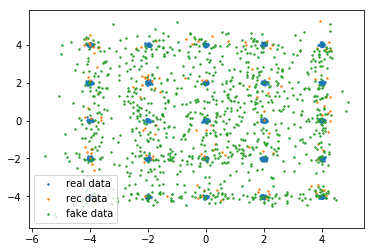

step 4000: KL: 5.060e+00, rec: 6.449e+00


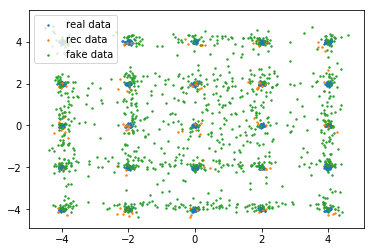

step 6000: KL: 5.361e+00, rec: 5.458e+00


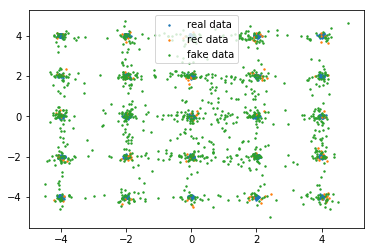

step 8000: KL: 5.398e+00, rec: 5.387e+00


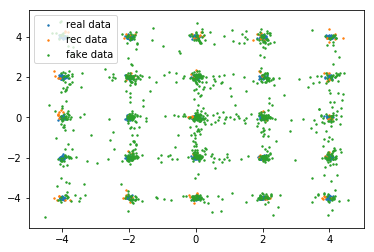

step 10000: KL: 5.015e+00, rec: 6.795e+00


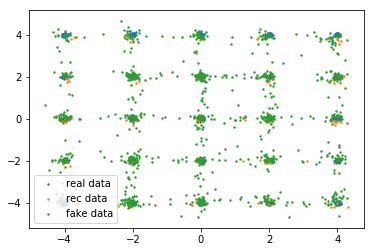

step 12000: KL: 5.221e+00, rec: 4.817e+00


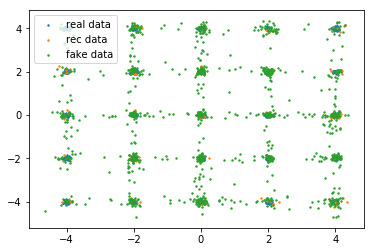

step 14000: KL: 5.485e+00, rec: 4.822e+00


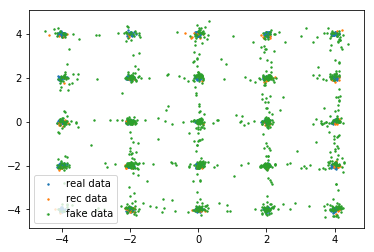

In [14]:
history = train_VAE(N_ITER = 14001, depth_enc = 3, width_enc = 100, depth_dec = 3, width_dec = 100, 
                    beta=0.5, learn_sigma=True, viz=True)

> Note : In order to be able to train the VAE, I had to downweight the KL divergence term, which can indeed be seen as a regularization term (as it measures how close the posterior $p(z|x)$ is to the prior $\mathcal{N}(0,Id)$). Thus the cost function I finally minimized is :

> $$\mathcal{L^{\beta}} = \beta D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ] $$ 

> and I figured out that $\beta=0.5$ was a satisfactory value.

> When $\beta$ was equal to 1, the original data was perfectly reconstructed but the generated dots were not realistic at all (all concentrated inside a ball around the origin). Actually, I could observe that the KL divergence converged very rapidly to zero, which means that the posterior probability became very rapidly close to the prior. Hence, I could guess that the encoder was too much constrained by the prior at the beginning of the training, while the decoder was enough expressive to reconstruct the original data from a bad encoding. This led me to downweight the regularization term, and found this trick to be used in practice in the litterature (cf. for instance here http://proceedings.mlr.press/v70/kusner17a/kusner17a-supp.pdf).

**Q13: Try hardcoding $\sigma_\theta(z)$ to some small value (like 0.01) rather than allowing the decoder to learn it. What does it change?**

step 2000: KL: 9.314e+00, rec: 8.187e+00


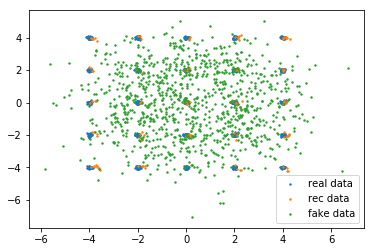

step 4000: KL: 7.207e+00, rec: 7.597e+00


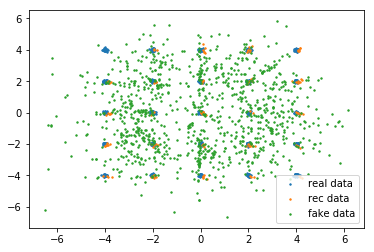

step 6000: KL: 7.085e+00, rec: 5.424e+00


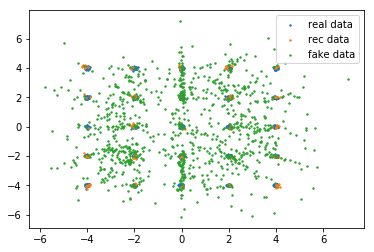

step 8000: KL: 6.556e+00, rec: 5.475e+00


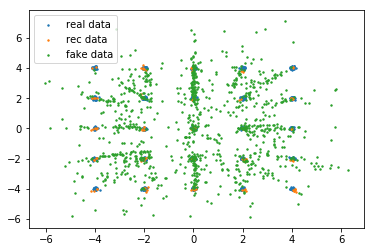

step 10000: KL: 6.609e+00, rec: 5.966e+00


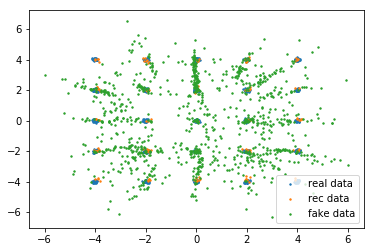

step 12000: KL: 6.601e+00, rec: 5.244e+00


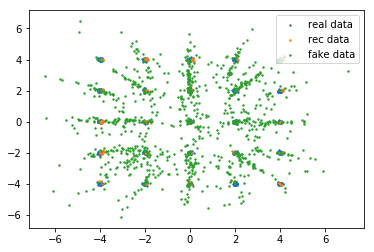

step 14000: KL: 6.477e+00, rec: 6.480e+00


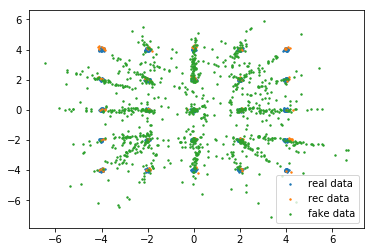

step 16000: KL: 6.435e+00, rec: 5.165e+00


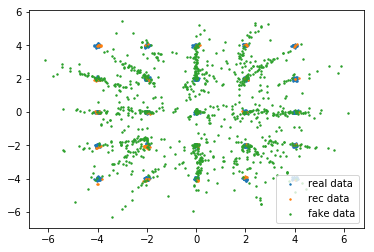

step 18000: KL: 6.342e+00, rec: 5.846e+00


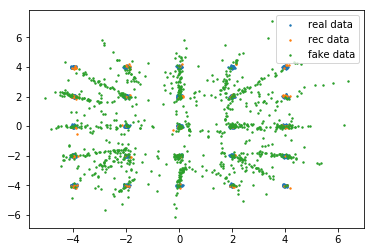

step 20000: KL: 6.182e+00, rec: 6.376e+00


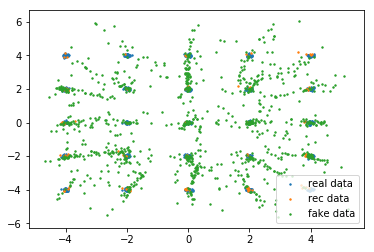

In [ ]:
history = train_VAE(N_ITER = 20001, depth_enc = 3, width_enc = 100, depth_dec = 3, width_dec = 100,
                    beta=1., learn_sigma=False, fixed_sigma=0.05, viz=True)

> Intuitively, if we hardcode the variance $\sigma_\theta(z)$ to a small value, we are helping the decoder as it has only to learn the means of the gaussians. However, we observe that, while we reconstruct perfectly the original data, we do not generate higher quality data than when we learnt the variances. Maybe this is due to the fact that the decoder is too expressive for its task, and does not need a good probabilistic encoding to do its job. 

> However, contrarily to the case where the variances were learnt (Q12), I could here make the VAE converge using the original loss $D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$, (ie. $\beta=1$). Hence this saved the effort of choosing the right weight of the regularization term.

**Q14: How do the power of encoder and decoder affect the overall training of the VAE?**

In [ ]:
depths = [2,3,4]
widths = [20,100,500]
N_ITER = 10000

nb_iter_average = 20 #computing moving average of loss over nb_iter_average iterations

fig, axes = plt.subplots(1, 1)
for d in depths:
    history = train_VAE(N_ITER = N_ITER, depth_enc = d, width_enc = 100, depth_dec = 3, width_dec = 100, 
                    beta=0.5, learn_sigma=True, viz=False)
    axes.plot(pd.Series(history).rolling(window=nb_iter_average).mean().values,label=d)
axes.legend()
plt.title("Influence of the depth of the encoder. Evolution of elbo (-loss)")
plt.show()

fig, axes = plt.subplots(1, 1)
for d in widths:
    history = train_VAE(N_ITER = N_ITER, depth_enc = 3, width_enc = d, depth_dec = 3, width_dec = 100, 
                    beta=0.5, learn_sigma=True, viz=False)
    axes.plot(pd.Series(history).rolling(window=nb_iter_average).mean().values,label=d)
axes.legend()
plt.title("Influence of the width of the encoder. Evolution of elbo (-loss)")
plt.show()

fig, axes = plt.subplots(1, 1)
for d in widths:
    history = train_VAE(N_ITER = N_ITER, depth_enc = 3, width_enc = 100, depth_dec = d, width_dec = 100, 
                    beta=0.5, learn_sigma=True, viz=False)
    plt.plot(pd.Series(history).rolling(window=nb_iter_average).mean().values,label="-(loss_kl+loss_rec)")
    axes.plot(history,label=d)
axes.legend()
plt.title("Influence of the depth of the decoder. Evolution of elbo (-loss)")
plt.show()

fig, axes = plt.subplots(1, 1)
for d in widths:
    history = train_VAE(N_ITER = N_ITER, depth_enc = 3, width_enc = 100, depth_dec = 3, width_dec = d, 
                    beta=0.5, learn_sigma=True, viz=False)
    axes.plot(pd.Series(history).rolling(window=nb_iter_average).mean().values,label=d)
axes.legend()
plt.title("Influence of the width of the decoder. Evolution of elbo (-loss)")
plt.show()

> *Note* : My computer allowed me to run only once or twice the VAE training per Jupyter session, as it systematically crashed after that ("dead kernel"). Thus, I did not manage to execute the cell above to properly study the impact of the various parameters (impact of the depth/width of the encoder/decoder on the elbo evolution). Thus, my discussion in this question will therefore be based on the several experiments I did to make the VAE training work (restarting the session each time).

> *Depths and widths of the encoder/decoder should be large enough.* Intuitively, if the width/depth of the encoder/decoder are not large enough, the networks wont be enough expressive to learn the gaussian mixture modelling of the data distribution. In addition, as for the GAN training, I found it more convenient to look for a satisfactory network depth first (highest impact), and then to refine the number of neurons per layer.

> *Depth and width of the decoder should not be too large.* Secondly, I make the the hypothesis that if the expressive power of the decoder is too large, then what can happen is that it will be able to reconstruct the original data even from a bad probabilistic encoding, while the samples generated from the prior $\mathcal{N(0,1)}$ will not be realistic at all. However, I found it easier in pratice to downweight the regularization term (KL divergence) constraining the encoder, than decreasing the power of the decoder.

**Q15: As a conclusion, how would you compare the advantages and shortcomings of GANs and VAEs?**

> **VAE** 

> *Advantages* :

> - VAE are **probabilistic models**, which aim first at finding a meaningful latent representation of the data, which then can be used for generative purposes. We **optimize a clear objective** (lower bound of the likelihood of the probabilistic model), which **provides a sanity check on the implementation** and **enables easier comparisons between models (therefore, easier hyperparameters tuning)**.

> - **The ability to introduce priors** to which the posterior probability of the latent variables must get close to may be interesting if we want to introduce prior knowledge or if we want to **learn interpretable latent dimensions**.

> *Drawbacks* : 

> - **It may be difficult to find a good prior in the latent space, ie. not too constraining to generate complex data distributions.**.

>  - **VAE have potentially the risk to put mass in regions of the latent space from which generated data will be unrealistic** ($D_{KL}(q_\phi(z | x) \| p(z))$ assigns a low penalty when $q_\phi(z | x) \rightarrow 0$ and $p(z)>0$).


>**GAN** 

> *Advantages* : 

> - **GAN are explicitely designed for the generative task**. The JSD enables to penalize both missed modes of the distribution and unrealistic images (compromise between the two asymetric KL divergences).

> *Drawbacks* : 

> - **The competitive training of the discriminator and of the generator is hard in practice.** The two players of the game, the generator and the discriminator, should learn at similar paces to reach an equilibrium. Depending on the performance of the discriminator,  it can happen that the generator optimizes a very bad objective - if the discriminator is too bad - or receives a very weak feedback - if it is too good. 

> - **We do not optimize a clear objective function, which makes comparison between different models difficult, which can be notably problematic for hyperparameters tuning** : the generator loss can increase (it does less well with respect to its opponent, the discriminator) while the quality of the generated data can increase too !